In [1]:
import getopt
import sys
import gc
import os
sys.path.append('/home/atac2rna/program/atac2rna/Model/butterfly/Butterfly')
sys.path.append('/home/atac2rna/program/atac2rna/Model/butterfly/experiment/RNA_ADT')
from data_processing import RNA_data_preprocessing, ATAC_data_preprocessing
import scanpy as sc
import anndata as ad
import random
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from model_component import *
from model_utlis import *
from calculate_cluster import *
from draw_cluster import *
from relation_evaluation import *
from data_processing import *
import train_model_cite
import train_model

# load in data and align the genes

In [2]:
import getopt
import sys
import gc
import os
sys.path.append('/home/atac2rna/program/atac2rna/Model/22_10_10/')
from data_processing import RNA_data_preprocessing, ATAC_data_preprocessing
import scanpy as sc
import anndata as ad
    
sc_data = sc.read_h5ad('/home/atac2rna/data/atac2rna/data/openproblems_neurips2021/GSE194122_openproblems_neurips2021_multiome_BMMC_count.h5ad')
RNA_data_rna_atac = sc_data[:, 0:13431]
ATAC_data_rna_atac = sc_data[:, 13431:]
del sc_data
gc.collect()

RNA_data_rna_adt = sc.read_h5ad('/home/atac2rna/data/atac2rna/data/openproblems_neurips2021/bmmc_RNA_cnt.h5ad')
ADT_data_rna_adt = sc.read_h5ad('/home/atac2rna/data/atac2rna/data/openproblems_neurips2021/bmmc_ADT_CLRed.h5ad')

In [4]:
RNA_data_rna_adt.obs.cell_type.value_counts()

CD14+ Mono                          21693
CD4+ T activated                     6966
CD4+ T naive                         5897
NK                                   5434
Reticulocyte                         4272
Erythroblast                         4039
Naive CD20+ B IGKC+                  3990
CD8+ T naive                         3107
CD16+ Mono                           2635
NK CD158e1+                          2167
Naive CD20+ B IGKC-                  1979
G/M prog                             1881
pDC                                  1758
HSC                                  1703
cDC2                                 1702
Lymph prog                           1681
Transitional B                       1575
Proerythroblast                      1512
CD8+ T CD57+ CD45RO+                 1470
Normoblast                           1435
CD8+ T CD57+ CD45RA+                 1303
CD8+ T TIGIT+ CD45RO+                1160
CD4+ T activated integrinB7+         1056
CD8+ T TIGIT+ CD45RA+             

In [3]:
rna_atac_gene = RNA_data_rna_atac.var.index
rna_adt_gene = RNA_data_rna_adt.var.index
gene_list_rna_atac = []
gene_list_rna_adt = []
for i in range(len(rna_atac_gene)):
    for j in range(len(rna_adt_gene)):
        if rna_adt_gene[j] == rna_atac_gene[i]:
            gene_list_rna_atac.append(i)
            gene_list_rna_adt.append(j)
            break

In [4]:
import scipy.sparse as sp

In [5]:
big_RNA = ad.AnnData(X = sp.vstack((RNA_data_rna_adt.X[:, gene_list_rna_adt], RNA_data_rna_atac.X[:, gene_list_rna_atac])))

In [6]:
big_RNA.var = RNA_data_rna_atac.var.iloc[gene_list_rna_atac, :]

In [7]:
file_path = '/home/atac2rna/data/atac2rna/model_output/22_10_12/debug'

In [8]:
big_RNA = RNA_data_preprocessing(
    big_RNA,
    normalize_total=True,
    log1p=True,
    use_hvg=True,
    n_top_genes=3000,
    save_data=False,
    file_path=file_path,
    logging_path=file_path
    )

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

In [9]:
ATAC_data_rna_atac = ATAC_data_preprocessing(
    ATAC_data_rna_atac,
    binary_data=True,
    filter_features=True,
    fpeaks=0.005,
    tfidf=True,
    normalize=True,
    save_data=False,
    file_path=file_path,
    logging_path=file_path
)[0]

1


2
3


# split data

In [10]:
RNA_data_rna_atac = ad.AnnData(X=big_RNA.X[90261:, :], obs=RNA_data_rna_atac.obs, var=big_RNA.var)

In [11]:
RNA_data_rna_adt = ad.AnnData(X=big_RNA.X[0:90261, :], obs=RNA_data_rna_adt.obs, var=big_RNA.var)

In [12]:
number = 4

In [13]:
from split_datasets import *
id_list = bmmc_batch_split_dataset(RNA_data_rna_atac, ATAC_data_rna_atac)
train_id, validation_id, test_id = id_list[int(number) - 1]
train_id_r = train_id.copy()
train_id_a = train_id.copy()
validation_id_r = validation_id.copy()
validation_id_a = validation_id.copy()
test_id_r = test_id.copy()
test_id_a = test_id.copy()

In [14]:
RNA_input_dim = 3000
ATAC_input_dim = ATAC_data_rna_atac.X.shape[1]

R_kl_div = 1 / RNA_input_dim * 20
A_kl_div = R_kl_div
kl_div = R_kl_div + A_kl_div

In [15]:
chrom_list = []
last_one = ''
for i in range(len(ATAC_data_rna_atac.var.gene_id.index)):
    temp = ATAC_data_rna_atac.var.gene_id.index[i].split('-')[0]
    if temp[0 : 3] == 'chr':
        if not temp == last_one:
            chrom_list.append(1)
            last_one = temp
        else:
            chrom_list[-1] += 1
    else:
        chrom_list[-1] += 1

In [16]:
model_A2R = train_model.Model(
    R_encoder_nlayer = 2, 
    A_encoder_nlayer = 2,
    R_decoder_nlayer = 2, 
    A_decoder_nlayer = 2,
    R_encoder_dim_list = [RNA_input_dim, 256, 128],
    A_encoder_dim_list = [ATAC_input_dim, 32 * len(chrom_list), 128],
    R_decoder_dim_list = [128, 256, RNA_input_dim],
    A_decoder_dim_list = [128, 32 * len(chrom_list), ATAC_input_dim],
    R_encoder_act_list = [nn.LeakyReLU(), nn.LeakyReLU()],
    A_encoder_act_list = [nn.LeakyReLU(), nn.LeakyReLU()],
    R_decoder_act_list = [nn.LeakyReLU(), nn.LeakyReLU()],
    A_decoder_act_list = [nn.LeakyReLU(), nn.Sigmoid()],
    translator_embed_dim = 128, 
    translator_input_dim_r = 128,
    translator_input_dim_a = 128,
    translator_embed_act_list = [nn.LeakyReLU(), nn.LeakyReLU(), nn.LeakyReLU()],
    discriminator_nlayer = 1,
    discriminator_dim_list_R = [128],
    discriminator_dim_list_A = [128],
    discriminator_act_list = [nn.Sigmoid()],
    dropout_rate = 0.1,
    R_noise_rate = 0.5,
    A_noise_rate = 0.3,
    chrom_list = chrom_list,
    logging_path = file_path,
    RNA_data = RNA_data_rna_atac,
    ATAC_data = ATAC_data_rna_atac
)

In [17]:
model_R2A = train_model_cite.Model(
    R_encoder_nlayer = 2, 
    A_encoder_nlayer = 2,
    R_decoder_nlayer = 2, 
    A_decoder_nlayer = 2,
    R_encoder_dim_list = [RNA_input_dim, 256, 128],
    A_encoder_dim_list = [134, 128, 128],
    R_decoder_dim_list = [128, 256, RNA_input_dim],
    A_decoder_dim_list = [128, 128, 134],
    R_encoder_act_list = [nn.LeakyReLU(), nn.LeakyReLU()],
    A_encoder_act_list = [nn.LeakyReLU(), nn.LeakyReLU()],
    R_decoder_act_list = [nn.LeakyReLU(), nn.LeakyReLU()],
    A_decoder_act_list = [nn.LeakyReLU(), nn.Identity()],
    translator_embed_dim = 128, 
    translator_input_dim_r = 128,
    translator_input_dim_a = 128,
    translator_embed_act_list = [nn.LeakyReLU(), nn.LeakyReLU(), nn.LeakyReLU()],
    discriminator_nlayer = 1,
    discriminator_dim_list_R = [128],
    discriminator_dim_list_A = [128],
    discriminator_act_list = [nn.Sigmoid()],
    dropout_rate = 0.1,
    R_noise_rate = 0.5,
    A_noise_rate = 0,
    chrom_list = [],
    output_path = file_path,
    RNA_data = RNA_data_rna_adt,
    ATAC_data = ADT_data_rna_adt
)

# predict data

## atac to rna

In [18]:
model_path = "/home/atac2rna/data/atac2rna/model_output/22_10_12/Cite_test/A2R2A/A2R/C"   
model_A2R.RNA_encoder.load_state_dict(torch.load(model_path + '/model/RNA_encoder.pt'))
model_A2R.ATAC_encoder.load_state_dict(torch.load(model_path + '/model/ATAC_encoder.pt'))
model_A2R.RNA_decoder.load_state_dict(torch.load(model_path + '/model/RNA_decoder.pt'))
model_A2R.ATAC_decoder.load_state_dict(torch.load(model_path + '/model/ATAC_decoder.pt'))
model_A2R.translator.load_state_dict(torch.load(model_path + '/model/translator.pt'))

<All keys matched successfully>

In [19]:
R2A_predict = []
A2R_predict = []

""" load data """
RNA_input_dim = model_A2R.RNA_data.shape[1]
ATAC_input_dim = model_A2R.ATAC_data.shape[1]

model_A2R.test_dataset = Single_omics_dataset(model_A2R.ATAC_data, test_id_a)
model_A2R.test_dataloader = DataLoader(model_A2R.test_dataset, batch_size=100, shuffle=False, num_workers=4)

model_A2R.set_eval()
with torch.no_grad():
    with tqdm(total = len(model_A2R.test_dataloader), ncols=150, colour='blue') as pbar:
        pbar.set_description('RNA to ATAC predicting...')
        for idx, batch_samples in enumerate(model_A2R.test_dataloader):
            if torch.cuda.is_available():
                batch_samples = batch_samples.cuda().to(torch.float32)

            A2 = model_A2R.ATAC_encoder(batch_samples)
            A2R, A2A, mu_a, sigma_a = model_A2R.translator.test_model(A2, 'ATAC')
            A2R = model_A2R.RNA_decoder(A2R)

            A2R_predict.append(A2R.cpu())                       

            time.sleep(0.01)
            pbar.update(1)
            
A2R_predict = tensor2adata(A2R_predict)
A2R_predict.obs = RNA_data_rna_atac.obs.iloc[test_id_r, :]
A2R_predict.var = RNA_data_rna_atac.var

RNA to ATAC predicting...: 100%|████████████████████████████████████████████████████████████████████████████████████| 223/223 [00:39<00:00,  5.71it/s]


In [20]:
RNA_predict = A2R_predict

## rna to adt

In [21]:
model_path = "/home/atac2rna/data/atac2rna/model_output/22_10_12/Cite_test/A2R2A/R2A/C"   
model_R2A.RNA_encoder.load_state_dict(torch.load(model_path + '/model/RNA_encoder.pt'))
model_R2A.ATAC_encoder.load_state_dict(torch.load(model_path + '/model/ATAC_encoder.pt'))
model_R2A.RNA_decoder.load_state_dict(torch.load(model_path + '/model/RNA_decoder.pt'))
model_R2A.ATAC_decoder.load_state_dict(torch.load(model_path + '/model/ATAC_decoder.pt'))
model_R2A.translator.load_state_dict(torch.load(model_path + '/model/translator.pt'))

<All keys matched successfully>

In [22]:
R2A_predict = []
A2R_predict = []

""" load data """
RNA_input_dim = model_R2A.RNA_data.shape[1]
ATAC_input_dim = model_R2A.ATAC_data.shape[1]

model_R2A.test_dataset = Single_omics_dataset(RNA_predict.X.toarray(), [i for i in range(RNA_predict.X.shape[0])])
model_R2A.test_dataloader = DataLoader(model_R2A.test_dataset, batch_size=100, shuffle=False, num_workers=4)

model_R2A.set_eval()
with torch.no_grad():
    with tqdm(total = len(model_R2A.test_dataloader), ncols=150, colour='blue') as pbar:
        pbar.set_description('RNA to ATAC predicting...')
        for idx, batch_samples in enumerate(model_R2A.test_dataloader):
            if torch.cuda.is_available():
                batch_samples = batch_samples.cuda().to(torch.float32)

            R2 = model_R2A.RNA_encoder(batch_samples)
            R2R, R2A, mu_r, sigma_r = model_R2A.translator.test_model(R2, 'RNA')
            R2A = model_R2A.ATAC_decoder(R2A)
            R2A_predict.append(R2A.cpu())                       

            time.sleep(0.01)
            pbar.update(1)
            
R2A_predict = tensor2adata_adt(R2A_predict)
R2A_predict.obs = RNA_predict.obs
R2A_predict.var = ADT_data_rna_adt.var

RNA to ATAC predicting...: 100%|████████████████████████████████████████████████████████████████████████████████████| 223/223 [00:12<00:00, 18.08it/s]


In [23]:
ADT_predict = R2A_predict

# test predict

## virsualize predict

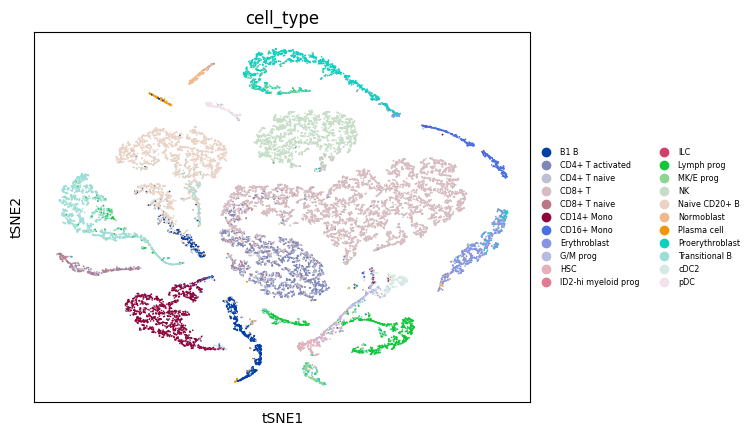

In [25]:
sc.pp.pca(ADT_predict)
sc.pp.neighbors(ADT_predict)
sc.tl.tsne(ADT_predict)
sc.pl.tsne(ADT_predict, color='cell_type', legend_fontsize='xx-small')

## calculate the cluster index

In [26]:
import scanpy as sc
import anndata as ad
import episcanpy as epi
import sklearn
from sklearn import metrics


def calculate_cluster_index(adata):
    """
    Evaluation of cluster index of prediction. 
    Cluster method have two types:  Leiden
                         Louvain. 
    Index have eight types:   Adjusted Rand Index
                      Rand Index
                      Normalized Mutual Information
                      Adjusted Mutual Information
                      Homogeneity
                      Completeness
                      V-measure
                      Fowlkes-Mallows Scores
    
    Parameters
    ----------
    adata
        Anndata need to calculate, it's worth noting that there should be 'cell_type' in adata.obs.
        
    """  
    sc.tl.leiden(adata)
    sc.tl.louvain(adata)

    ARI_leiden = metrics.adjusted_rand_score(adata.obs['cell_type'], adata.obs['leiden'])
    Rand_leiden = metrics.rand_score(adata.obs['cell_type'], adata.obs['leiden'])
    AMI_leiden = metrics.adjusted_mutual_info_score(adata.obs['cell_type'], adata.obs['leiden'])
    NMI_leiden = metrics.normalized_mutual_info_score(adata.obs['cell_type'], adata.obs['leiden'])
    HOM_leiden = metrics.homogeneity_score(adata.obs['cell_type'], adata.obs['leiden'])
    COM_leiden = metrics.completeness_score(adata.obs['cell_type'], adata.obs['leiden'])
    V_measure_leiden = metrics.v_measure_score(adata.obs['cell_type'], adata.obs['leiden'])
    FM_leiden = metrics.fowlkes_mallows_score(adata.obs['cell_type'], adata.obs['leiden'])
    
    return ARI_leiden, AMI_leiden, NMI_leiden, HOM_leiden, COM_leiden, V_measure_leiden

In [27]:
calculate_cluster_index(ADT_predict)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(0.2924768613983844,
 0.6650971632401174,
 0.6672446797400744,
 0.8132477940078305,
 0.5656864738731956,
 0.6672446797400743)

## check the rank genes group for each types

In [28]:
ADT_predict.obs.cell_type.value_counts() != 0

CD8+ T                  True
Naive CD20+ B           True
NK                      True
Transitional B          True
CD14+ Mono              True
CD4+ T activated        True
Proerythroblast         True
Lymph prog              True
B1 B                    True
Erythroblast            True
CD4+ T naive            True
CD16+ Mono              True
MK/E prog               True
G/M prog                True
HSC                     True
cDC2                    True
CD8+ T naive            True
Normoblast              True
pDC                     True
Plasma cell             True
ID2-hi myeloid prog    False
ILC                    False
Name: cell_type, dtype: bool

In [29]:
ADT_predict_ = ADT_predict[(ADT_predict.obs.cell_type != 'ID2-hi myeloid prog') &
                           (ADT_predict.obs.cell_type != 'ILC')]

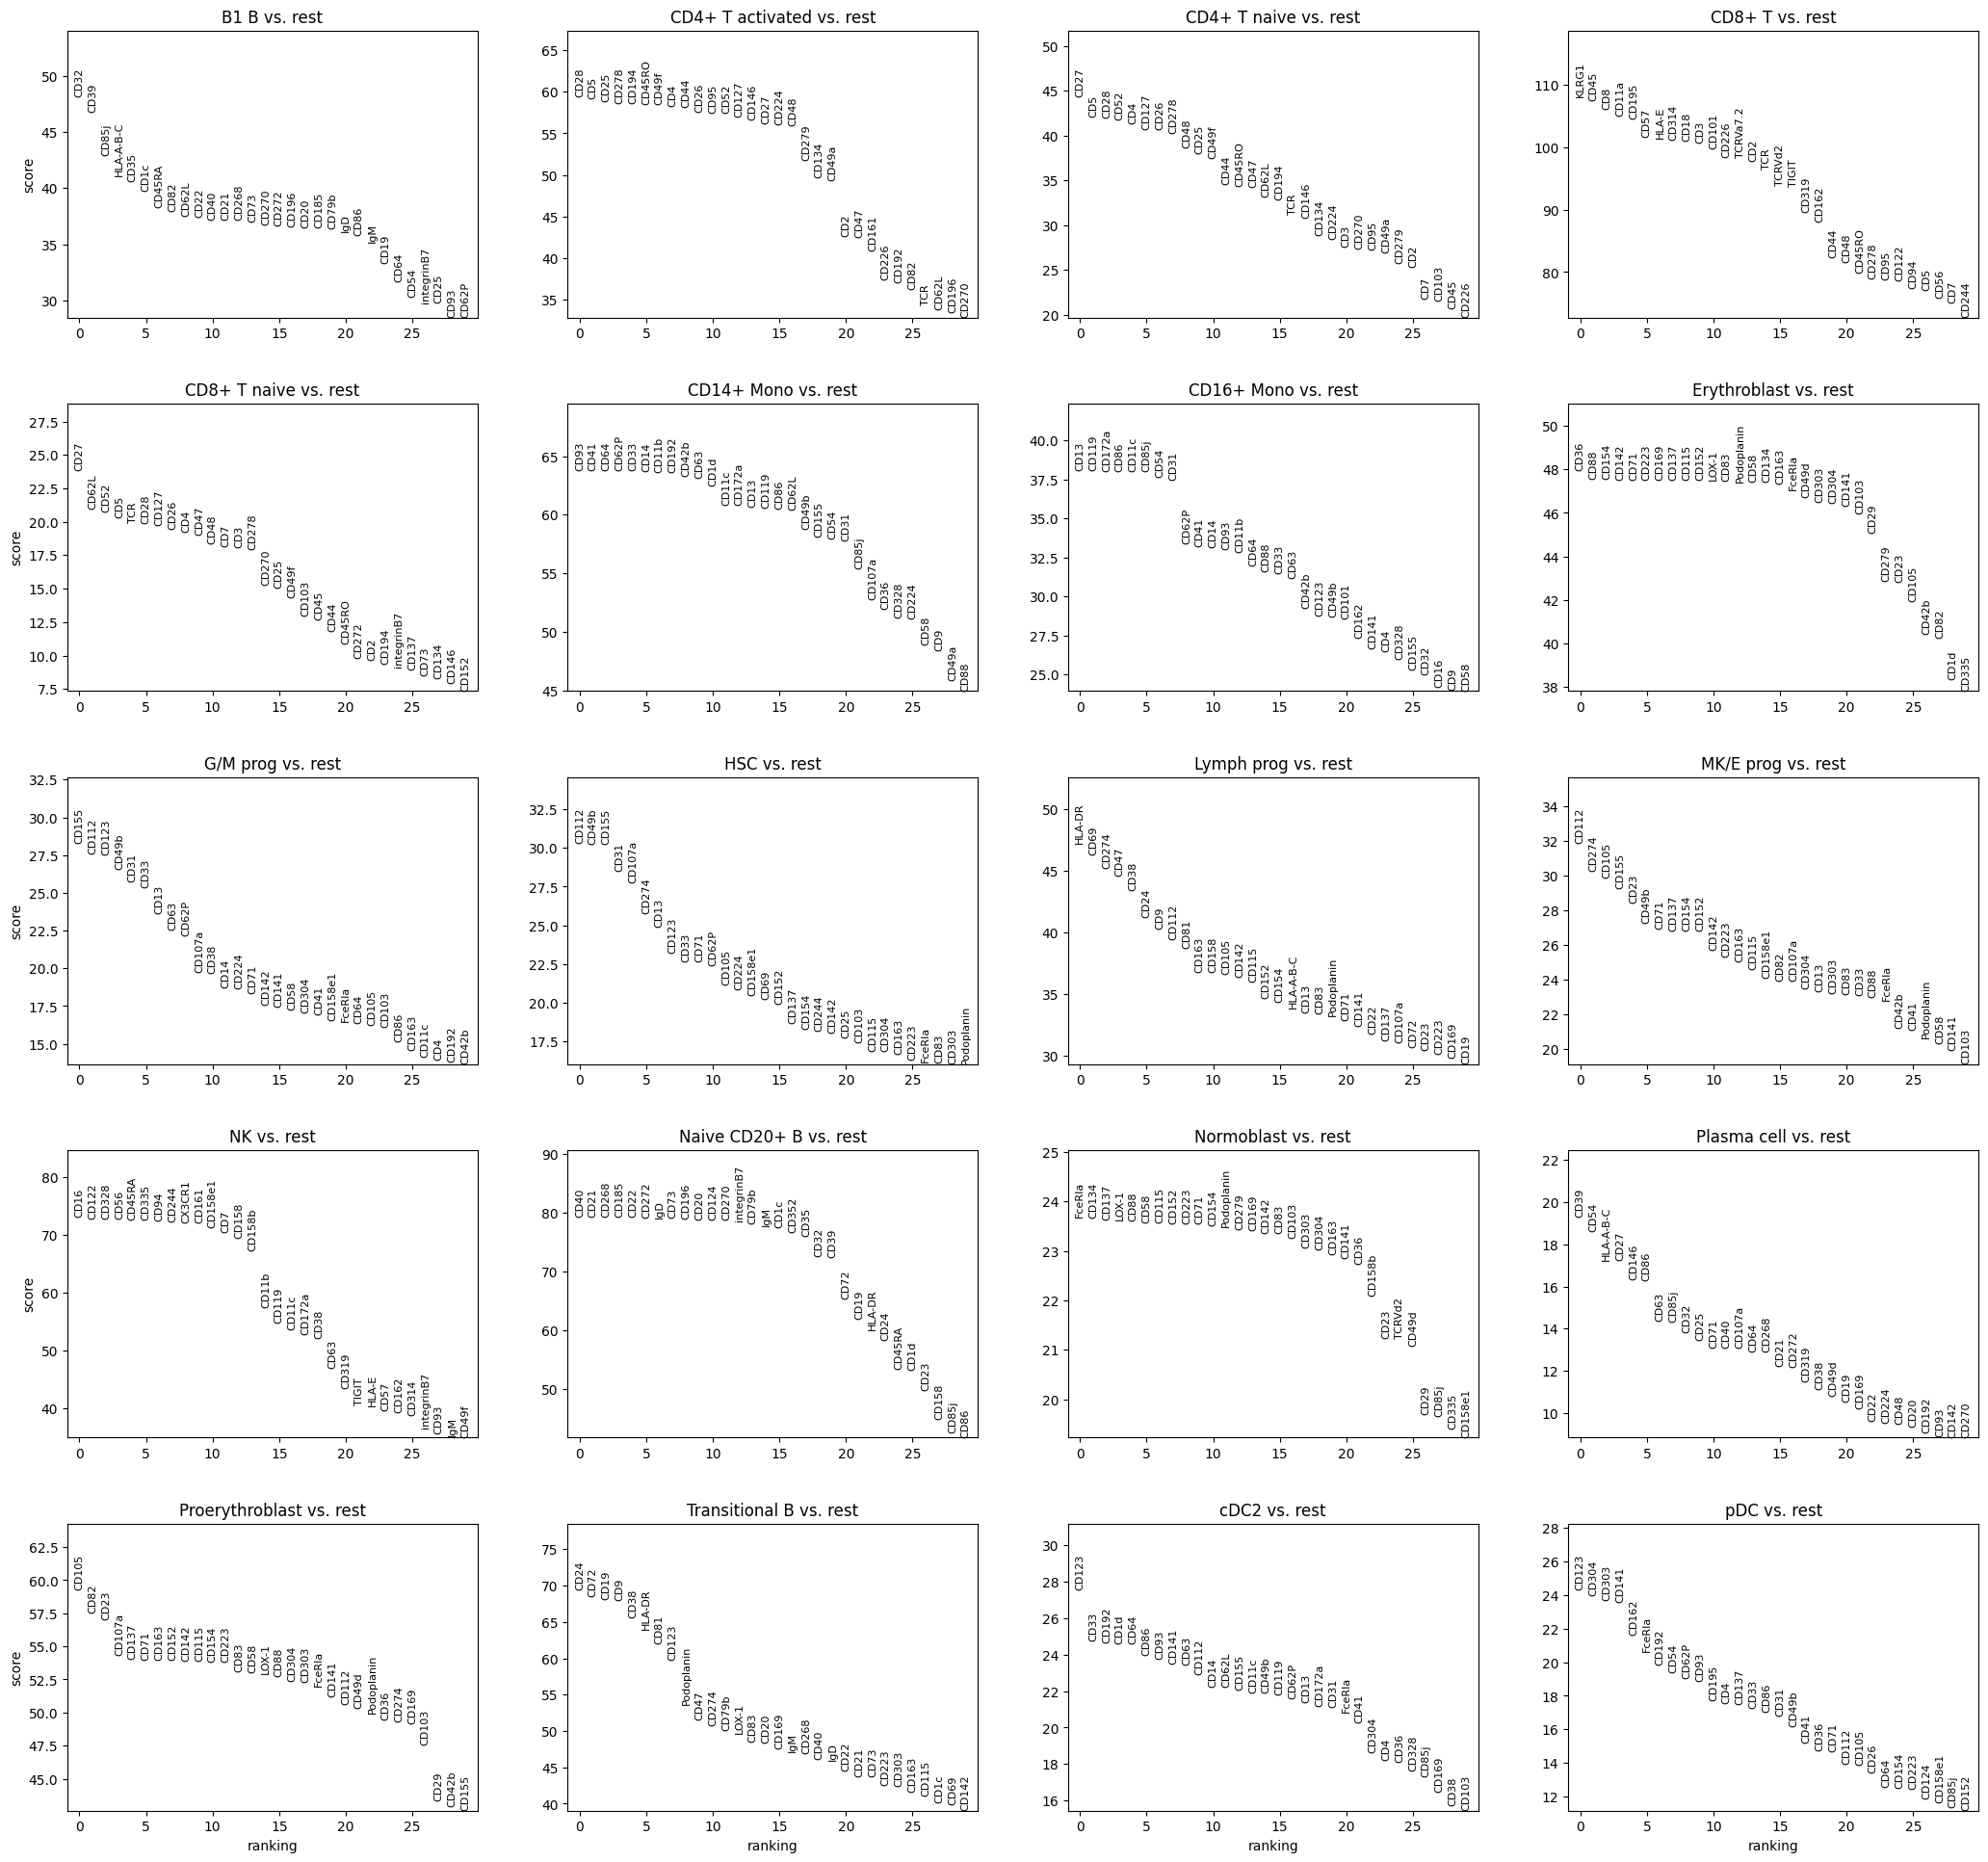

In [30]:
sc.tl.rank_genes_groups(ADT_predict_, groupby='cell_type', method='wilcoxon')
sc.pl.rank_genes_groups(ADT_predict_, n_genes=30, sharey=False)